## Anime Recommender

This is an updated version of the Anime Recommender project. This version uses an new an updated version of the dataset.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline
import re

### The dataset
See the webscrape script in the raw_data folder

In [3]:
anime_db = pd.read_csv('../data/My_Anime_List_uncleaned.csv')

In [4]:
anime_db.head()

,Unnamed: 0,name,type,episodes,members,score_members,rating,genre,dates,url
0,0,Fullmetal Alchemist: Brotherhood,TV,64.0,1777286.0,1085943.0,9.23,"['Action', 'Military', 'Adventure', 'Comedy', ...",Apr 2009 - Jul 2010,https://myanimelist.net/anime/5114/Fullmetal_A...
1,1,Steins;Gate,TV,24.0,1450929.0,796015.0,9.13,"['Thriller', 'Sci-Fi']",Apr 2011 - Sep 2011,https://myanimelist.net/anime/9253/Steins_Gate
2,2,Gintama°Gintama Season 4,TV,51.0,313855.0,110913.0,9.12,"['Action', 'Comedy', 'Historical', 'Parody', '...",Apr 2015 - Mar 2016,https://myanimelist.net/anime/28977/Gintama°
3,3,Hunter x Hunter (2011)Hunter x Hunter,TV,148.0,1197308.0,679156.0,9.12,"['Action', 'Adventure', 'Fantasy', 'Shounen', ...",Oct 2011 - Sep 2014,https://myanimelist.net/anime/11061/Hunter_x_H...
4,4,Ginga Eiyuu DensetsuLegend of the Galactic Heroes,OVA,110.0,189727.0,43203.0,9.11,"['Military', 'Sci-Fi', 'Space', 'Drama']",Jan 1988 - Mar 1997,https://myanimelist.net/anime/820/Ginga_Eiyuu_...


In [5]:
anime_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16750 entries, 0 to 16749
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     16750 non-null  int64  
 1   name           160 non-null    object 
 2   type           16750 non-null  object 
 3   episodes       16256 non-null  float64
 4   members        16750 non-null  float64
 5   score_members  157 non-null    float64
 6   rating         157 non-null    float64
 7   genre          160 non-null    object 
 8   dates          16750 non-null  object 
 9   url            16750 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 1.3+ MB


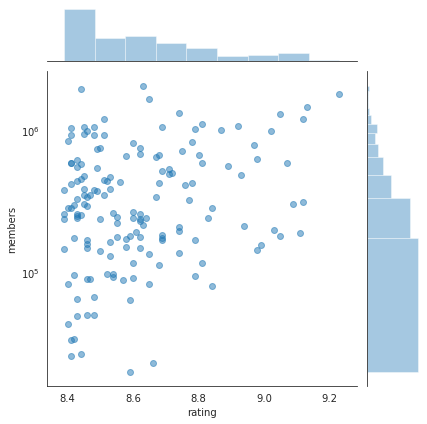

In [6]:
sns.jointplot(x='rating',y='members',data=anime_db,alpha=0.5)
plt.yscale('log')

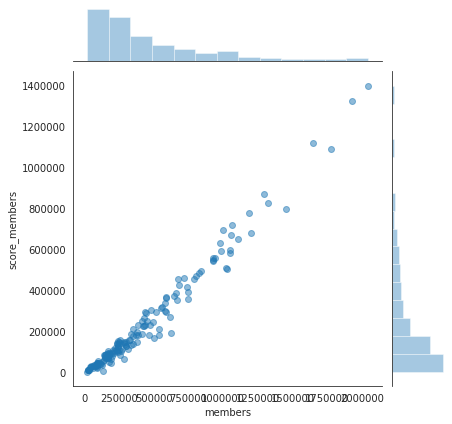

In [13]:
sns.jointplot(x='members',y='score_members',data=anime_db,alpha=0.5)

In [14]:
#check missing values
anime_db.isnull().sum().sort_values(ascending=False)/len(anime_db)

rating           0.990627
score_members    0.990627
genre            0.990448
name             0.990448
episodes         0.029493
url              0.000000
dates            0.000000
members          0.000000
type             0.000000
Unnamed: 0       0.000000
dtype: float64

In [26]:
anime_db["name"].isnull().sum()

16590

In [24]:
anime_db["name"][160:180]

160    NaN
161    NaN
162    NaN
163    NaN
164    NaN
165    NaN
166    NaN
167    NaN
168    NaN
169    NaN
170    NaN
171    NaN
172    NaN
173    NaN
174    NaN
175    NaN
176    NaN
177    NaN
178    NaN
179    NaN
Name: name, dtype: object

In [7]:
#repalce missing ratings with average
anime_db['rating'].fillna(anime_db["rating"].median(),inplace = True)

In [18]:
#replace missing types with 'unknown'
anime_db['type'].fillna('T/M',inplace = True)

In [26]:
anime_features = pd.concat([anime_db.genre.str.get_dummies(sep=","),
                            pd.get_dummies(anime_db['type']),anime_db.rating],axis=1)

In [28]:
anime_features.head()

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Vampire,Yaoi,Movie,Music,ONA,OVA,Special,T/M,TV,rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,9.37
1,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,9.26
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,9.25
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,9.17
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,9.16


In [34]:
#remove special characters from the names
anime_db["name"] = anime_db["name"].map(lambda name:re.sub('[^A-Za-z0-9]+', " ", name))

In [44]:
#use MaxBsScaler to scale the features from 1-0, while preserving sparsity
from sklearn.preprocessing import MaxAbsScaler
max_abs_scaler = MaxAbsScaler()
anime_features = max_abs_scaler.fit_transform(anime_features)

In [36]:
#build a model using the unsupervised verion of K-Nearest Neighbors
from sklearn.neighbors import NearestNeighbors

In [66]:
nn_model = NearestNeighbors(n_neighbors=10,algorithm='auto').fit(anime_features)

In [67]:
#Obtain the indices of and distances to the the nearest K neighbors of each point.
distances, indices = nn_model.kneighbors(anime_features)

In [147]:
def similar_anime_content(query):
    if query not in anime_db['name']:
        N = anime_db[anime_db['name'] == query].index[0]
        print('Similar Anime to "{}":'.format(query))
        for n in indices[N][1:]:
            print('Anime: {} \n Genre: {}; Average ratings: {}; Format: {}'.format(anime_db.name[n],
                                                                      anime_db.genre[n],
                                                                      anime_db.rating[n],anime_db['type'][n])) 
        
    else:
        print('The anime {} does not exist in our database.'.format(query))

In [148]:
similar_anime_content('Berserk')

Similar Anime to "Berserk":
Anime: Berserk 2016  
 Genre: Action, Adventure, Demons, Drama, Fantasy, Horror, Military, Romance, Seinen, Supernatural; Average ratings: 6.81; Format: TV
Anime: Berserk 2017  
 Genre: Action, Adventure, Demons, Drama, Fantasy, Horror, Magic, Military, Romance, Supernatural; Average ratings: 6.57; Format: TV
Anime: Berserk Ougon Jidai hen III Kourin 
 Genre: Action, Adventure, Demons, Drama, Fantasy, Horror, Military, Seinen, Supernatural; Average ratings: 8.33; Format: Movie
Anime: Berserk Ougon Jidai hen II Doldrey Kouryaku 
 Genre: Action, Adventure, Demons, Drama, Fantasy, Horror, Military, Seinen, Supernatural; Average ratings: 8.09; Format: Movie
Anime: Berserk Ougon Jidai hen I Haou no Tamago 
 Genre: Action, Adventure, Demons, Fantasy, Military, Seinen, Supernatural; Average ratings: 7.91; Format: Movie
Anime: Elfen Lied 
 Genre: Action, Drama, Horror, Psychological, Romance, Seinen, Supernatural; Average ratings: 7.85; Format: TV
Anime: Shakugan no

In [103]:
name_string = anime_db.name.str.split(' ')

In [151]:
def similar_anime_by_name(query):  
    n = 0
    print('Similar Anime to "{}":'.format(query))
    for i, name in enumerate(anime_db.name):
        if query in name:
            print('Anime: {}; Format: {}'.format(anime_db.name[i],anime_db['type'][i]))
            n+=1
    if n == 0:
        print('No anime with a name similar to "{}" exists in our database.'.format(query))


In [152]:
similar_anime_by_name('Berserk')

Similar Anime to "Berserk":
Anime: Berserk; Format: TV
Anime: Berserk Ougon Jidai hen III Kourin; Format: Movie
Anime: Berserk Ougon Jidai hen II Doldrey Kouryaku; Format: Movie
Anime: Berserk Ougon Jidai hen I Haou no Tamago; Format: Movie
Anime: Berserk 2016 ; Format: TV
Anime: Berserk 2017 ; Format: TV


In [158]:
anime_db[anime_db.members > 100].sort_values('rating',ascending=False).head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama 039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu Karasuno Koukou VS Shiratorizawa Gakue...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter 2011,"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
9,15417,Gintama 039 Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109
8,15335,Gintama Movie Kanketsu hen Yorozuya yo Eien Nare,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534


In [163]:
anime_db[anime_db['type'] == 'Movie'][anime_db.members > 100].sort_values('rating',ascending=False).head(10)

/home/mbcxjhr2/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
8,15335,Gintama Movie Kanketsu hen Yorozuya yo Eien Nare,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
11,28851,Koe no Katachi,"Drama, School, Shounen",Movie,1,9.05,102733
15,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1,8.93,466254
18,12355,Ookami Kodomo no Ame to Yuki,"Fantasy, Slice of Life",Movie,1,8.84,226193
24,164,Mononoke Hime,"Action, Adventure, Fantasy",Movie,1,8.81,339556
25,7311,Suzumiya Haruhi no Shoushitsu,"Comedy, Mystery, Romance, School, Sci-Fi, Supe...",Movie,1,8.81,240297
33,28957,Mushishi Zoku Shou Suzu no Shizuku,"Adventure, Fantasy, Historical, Mystery, Seine...",Movie,1,8.75,32266
35,431,Howl no Ugoku Shiro,"Adventure, Drama, Fantasy, Romance",Movie,1,8.74,333186
37,31757,Kizumonogatari II Nekketsu hen,"Action, Mystery, Supernatural, Vampire",Movie,1,8.73,34347
